# Playground competition Season 4 episode 1 - First Model

## ETL

First we are going to do the ETL, performing every step through this notebook.

The first step is to create a folder where you will store the project and create or clone this notebook to start working.

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
import itertools

### Train.csv

In [36]:
df_train = pd.read_csv('Datasets/train.csv') # using pandas to read the test set
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [37]:
useless_cols = ['id','CustomerId','Surname']
df_train.drop(columns=useless_cols,inplace=True)
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [38]:
string_cols = ['Geography','Gender']
target = ['Exited']

df_train = pd.get_dummies(df_train,columns=string_cols,dtype=int)
df_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0,0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,0,0,1,1,0
165030,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,1,0,0,0,1
165031,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,1,0,0,0,1
165032,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0,0,1,1,0


## ML Model

In [39]:
X = df_train.drop(columns='Exited')
y = df_train.Exited

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [42]:
models = {
    #'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(eval_metric='auc'),
    #'RandomForest': RandomForestClassifier(),
    #'GradientBoosting': GradientBoostingClassifier()
}

param_grids = {
    #'LightGBM':{'n_estimators': [10,30,50, 100, 200],'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [ 30,50,70], 'max_depth': [5, 7,10],'booster':['gbtree'],'eta':[0.1,0.05]},
    #'RandomForest': {'n_estimators': [50], 'max_depth': [None, 10]},
    #'GradientBoosting': {'n_estimators': [50], 'max_depth': [3, 7]}
}

results = []

for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    y_pred = grid_search.predict_proba(X_test)[:,1]
    accuracy = roc_auc_score(y_test, y_pred)

    result = {
        'Model': model_name,
        'Best_Params': best_params,
        'Test_auc': accuracy
    }
    results.append(result)
    print(f'Finalizado el analisis de {model_name}\n')
    print(result)

results_df = pd.DataFrame(results)
results_df


Finalizado el analisis de XGBoost

{'Model': 'XGBoost', 'Best_Params': {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 7, 'n_estimators': 70}, 'Test_Accuracy': 0.8635440967067591}


,Model,Best_Params,Test_Accuracy
0,XGBoost,"{'booster': 'gbtree', 'eta': 0.1, 'max_depth':...",0.863544


### Undersampling

In [40]:
# Concatenate X_train and y_train to prepare for undersampling
train_data = pd.concat([X_train, y_train], axis=1)

# Count the number of samples in each class
class_counts = train_data['Exited'].value_counts()

# Determine the minimum count of the target class (class 1)
min_class_count = class_counts.min()

# Undersample the majority class (class 0) to match the count of the target class
class_0_sampled = train_data[train_data['Exited'] == 0].sample(n=min_class_count, random_state=42)

# Keep all samples from the target class (class 1)
class_1 = train_data[train_data['Exited'] == 1]

# Concatenate the undersampled majority class and the target class
undersampled_data = pd.concat([class_0_sampled, class_1], axis=0)

# Shuffle the undersampled data
undersampled_data = undersampled_data.sample(frac=1, random_state=42)

# Separate the features and target after undersampling
X_train_resampled = undersampled_data.drop('Exited', axis=1)
y_train_resampled = undersampled_data['Exited']

In [41]:
models = {
    #'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(eval_metric='auc'),
    #'RandomForest': RandomForestClassifier(),
    #'GradientBoosting': GradientBoostingClassifier()
}

param_grids = {
    #'LightGBM':{'n_estimators': [10,30,50, 100, 200],'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [ 30,50,70], 'max_depth': [5, 7,10],'booster':['gbtree'],'eta':[0.1,0.05]},
    #'RandomForest': {'n_estimators': [50], 'max_depth': [None, 10]},
    #'GradientBoosting': {'n_estimators': [50], 'max_depth': [3, 7]}
}

results = []

for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train_resampled, y_train_resampled)

    best_params = grid_search.best_params_
    y_pred = grid_search.predict_proba(X_test)[:,1]
    accuracy = roc_auc_score(y_test, y_pred)

    result = {
        'Model': model_name,
        'Best_Params': best_params,
        'Test_auc': accuracy
    }
    results.append(result)
    print(f'Finalizado el analisis de {model_name}\n')
    print(result)

results_df = pd.DataFrame(results)
results_df


Finalizado el analisis de XGBoost

{'Model': 'XGBoost', 'Best_Params': {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 5, 'n_estimators': 70}, 'Test_Accuracy': 0.813221437876814}


,Model,Best_Params,Test_Accuracy
0,XGBoost,"{'booster': 'gbtree', 'eta': 0.1, 'max_depth':...",0.813221


No good....

### Oversampling

In [45]:
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [46]:
models = {
    #'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(eval_metric='auc'),
    #'RandomForest': RandomForestClassifier(),
    #'GradientBoosting': GradientBoostingClassifier()
}

param_grids = {
    #'LightGBM':{'n_estimators': [10,30,50, 100, 200],'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [ 30,50,70], 'max_depth': [5, 7,10],'booster':['gbtree'],'eta':[0.1,0.05]},
    #'RandomForest': {'n_estimators': [50], 'max_depth': [None, 10]},
    #'GradientBoosting': {'n_estimators': [50], 'max_depth': [3, 7]}
}

results = []

for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train_resampled, y_train_resampled)

    best_params = grid_search.best_params_
    y_pred = grid_search.predict_proba(X_test)[:,1]
    accuracy = roc_auc_score(y_test, y_pred)

    result = {
        'Model': model_name,
        'Best_Params': best_params,
        'Test_Auc': accuracy
    }
    results.append(result)
    print(f'Finalizado el analisis de {model_name}\n')
    print(result)

results_df = pd.DataFrame(results)
results_df


Finalizado el analisis de XGBoost

{'Model': 'XGBoost', 'Best_Params': {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 10, 'n_estimators': 70}, 'Test_Accuracy': 0.8274002484321508}


,Model,Best_Params,Test_Accuracy
0,XGBoost,"{'booster': 'gbtree', 'eta': 0.1, 'max_depth':...",0.8274


A little better but nope...

### Balance categorization

In [49]:
df_train['Balance'] = df_train.Balance.apply(lambda x: 0 if x == 0 else 1)
df_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0,2,1.0,0.0,181449.97,0,1,0,0,0,1
1,627,33.0,1,0,2,1.0,1.0,49503.50,0,1,0,0,0,1
2,678,40.0,10,0,2,1.0,0.0,184866.69,0,1,0,0,0,1
3,581,34.0,2,1,1,1.0,1.0,84560.88,0,1,0,0,0,1
4,716,33.0,5,0,2,1.0,1.0,15068.83,0,0,0,1,0,1


In [50]:
X = df_train.drop(columns='Exited')
y = df_train.Exited

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [51]:
models = {
    #'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(eval_metric='auc'),
    #'RandomForest': RandomForestClassifier(),
    #'GradientBoosting': GradientBoostingClassifier()
}

param_grids = {
    #'LightGBM':{'n_estimators': [10,30,50, 100, 200],'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [ 30,50,70], 'max_depth': [5, 7,10],'booster':['gbtree'],'eta':[0.1,0.05]},
    #'RandomForest': {'n_estimators': [50], 'max_depth': [None, 10]},
    #'GradientBoosting': {'n_estimators': [50], 'max_depth': [3, 7]}
}

results = []

for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    y_pred = grid_search.predict_proba(X_test)[:,1]
    accuracy = roc_auc_score(y_test, y_pred)

    result = {
        'Model': model_name,
        'Best_Params': best_params,
        'Test_auc': accuracy
    }
    results.append(result)
    print(f'Finalizado el analisis de {model_name}\n')
    print(result)

results_df = pd.DataFrame(results)
results_df

Finalizado el analisis de XGBoost

{'Model': 'XGBoost', 'Best_Params': {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 5, 'n_estimators': 70}, 'Test_Accuracy': 0.8665434604780804}


,Model,Best_Params,Test_Accuracy
0,XGBoost,"{'booster': 'gbtree', 'eta': 0.1, 'max_depth':...",0.866543


Good one!!

### Final estimation I

In [60]:
from sklearn.metrics import roc_auc_score

best_model = None
best_columns = None
best_accuracy = 0.0
all_columns = X.columns

models = {
    'XGBoost': XGBClassifier(eval_metric='auc')
}

param_grids = {
    'XGBoost': {'n_estimators': [50, 70, 100], 'max_depth': [3, 5, 7], 'booster': ['gbtree'], 'eta': [0.3, 0.1]}
}

results = []
wanted_list = ['Geography_Germany','Age','IsActiveMember','NumOfProducts','Balance']

for model_name, model in models.items():
    for r in range(1, len(all_columns) + 1):
        for columns_combination in itertools.combinations(all_columns, r):
            if not set(wanted_list).issubset(columns_combination):
                continue
            param_grid = param_grids[model_name]
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
            
            # Create a new DataFrame with the columns selected
            X_train_subset = X_train[list(columns_combination)]

            grid_search.fit(X_train_subset, y_train)

            best_params = grid_search.best_params_
            y_pred = grid_search.predict_proba(X_test[list(columns_combination)])[:,1]
            accuracy = roc_auc_score(y_test, y_pred)

            result = {
                'Model': model_name,
                'Columns': columns_combination,
                'Best_Params': best_params,
                'Test_Accuracy': accuracy
            }
            results.append(result)
            print(f'Finalizado el análisis de {model_name} con columnas {columns_combination}\n')
            print(result)

# Find the best combination of model, columns, and accuracy
best_result = max(results, key=lambda x: x['Test_Accuracy'])
best_model = best_result['Model']
best_columns = best_result['Columns']
best_accuracy = best_result['Test_Accuracy']

print("Best Model:", best_model)
print("Best Columns:", best_columns)
print("Best Accuracy:", best_accuracy)


Finalizado el análisis de XGBoost con columnas ('Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography_Germany')

{'Model': 'XGBoost', 'Columns': ('Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography_Germany'), 'Best_Params': {'booster': 'gbtree', 'eta': 0.3, 'max_depth': 3, 'n_estimators': 100}, 'Test_Accuracy': 0.8824602533515267}
Finalizado el análisis de XGBoost con columnas ('CreditScore', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography_Germany')

{'Model': 'XGBoost', 'Columns': ('CreditScore', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography_Germany'), 'Best_Params': {'booster': 'gbtree', 'eta': 0.3, 'max_depth': 3, 'n_estimators': 70}, 'Test_Accuracy': 0.8833010319666553}
Finalizado el análisis de XGBoost con columnas ('Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography_Germany')

{'Model': 'XGBoost', 'Columns': ('Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography_Germany'), 'Best_Para

In [61]:
print(best_columns)
params_final = best_result['Best_Params']
print(params_final)

('CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Female')
{'booster': 'gbtree', 'eta': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [62]:
final_model = XGBClassifier(**params_final,eval_metric='auc')
X_final = X[list(best_columns)]
y_final = y
final_model.fit(X_final,y_final)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='auc',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

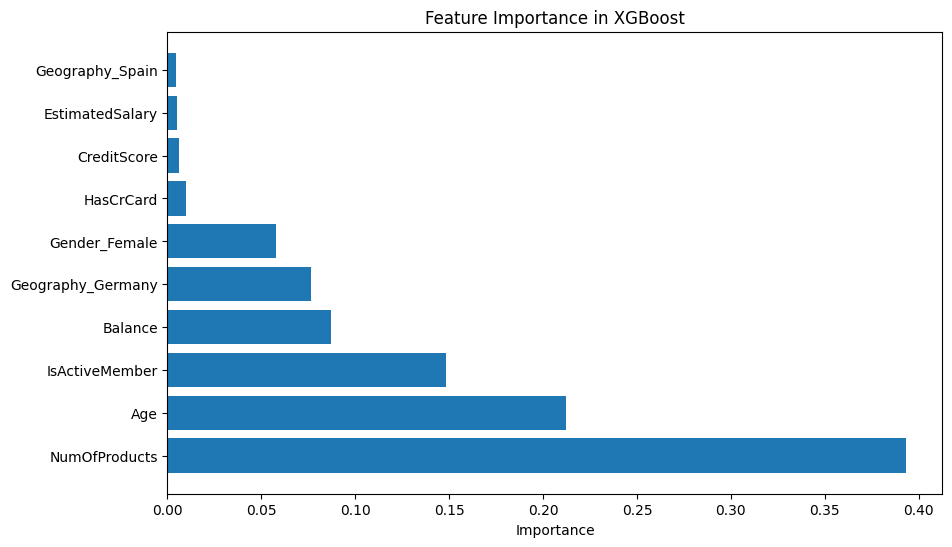

In [63]:
# Obtener la importancia de las características
feature_importance = final_model.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
feature_importance_df = pd.DataFrame({
    'Feature': best_columns,
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost')
plt.show()

In [64]:
df_test = pd.read_csv('Datasets/test.csv')

df_test

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,275055,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [65]:
df_test = pd.get_dummies(df_test,columns=string_cols,dtype=int)
df_test

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,165034,15773898,Lucchese,586,23.0,2,0.00,2,0.0,1.0,160976.75,1,0,0,1,0
1,165035,15782418,Nott,683,46.0,2,0.00,1,1.0,0.0,72549.27,1,0,0,1,0
2,165036,15807120,K?,656,34.0,7,0.00,2,1.0,0.0,138882.09,1,0,0,1,0
3,165037,15808905,O'Donnell,681,36.0,8,0.00,1,1.0,0.0,113931.57,1,0,0,0,1
4,165038,15607314,Higgins,752,38.0,10,121263.62,1,1.0,0.0,139431.00,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,29.0,7,116099.82,1,1.0,1.0,148087.62,0,0,1,0,1
110019,275053,15774133,Cox,575,36.0,4,178032.53,1,1.0,1.0,42181.68,1,0,0,1,0
110020,275054,15728456,Ch'iu,712,31.0,2,0.00,2,1.0,0.0,16287.38,1,0,0,0,1
110021,275055,15687541,Yegorova,709,32.0,3,0.00,1,1.0,1.0,158816.58,1,0,0,1,0


In [66]:
df_test['Balance'] = df_test.Balance.apply(lambda x: 0 if x == 0 else 1)
df_test.head(5)

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,165034,15773898,Lucchese,586,23.0,2,0,2,0.0,1.0,160976.75,1,0,0,1,0
1,165035,15782418,Nott,683,46.0,2,0,1,1.0,0.0,72549.27,1,0,0,1,0
2,165036,15807120,K?,656,34.0,7,0,2,1.0,0.0,138882.09,1,0,0,1,0
3,165037,15808905,O'Donnell,681,36.0,8,0,1,1.0,0.0,113931.57,1,0,0,0,1
4,165038,15607314,Higgins,752,38.0,10,1,1,1.0,0.0,139431.00,0,1,0,0,1


In [67]:
df_test.drop(columns=['CustomerId','Surname'],inplace=True)

In [68]:
X_final_test = df_test[list(best_columns)]
X_final_test

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Female
0,586,23.0,0,2,0.0,1.0,160976.75,0,0,1
1,683,46.0,0,1,1.0,0.0,72549.27,0,0,1
2,656,34.0,0,2,1.0,0.0,138882.09,0,0,1
3,681,36.0,0,1,1.0,0.0,113931.57,0,0,0
4,752,38.0,1,1,1.0,0.0,139431.00,1,0,0
...,...,...,...,...,...,...,...,...,...,...
110018,570,29.0,1,1,1.0,1.0,148087.62,0,1,0
110019,575,36.0,1,1,1.0,1.0,42181.68,0,0,1
110020,712,31.0,0,2,1.0,0.0,16287.38,0,0,0
110021,709,32.0,0,1,1.0,1.0,158816.58,0,0,1


In [69]:
predictions = final_model.predict_proba(X_final_test)[:,1]
predictions

array([0.02677557, 0.8153843 , 0.02666428, ..., 0.01842767, 0.15410691,
       0.18942276], dtype=float32)

In [70]:
columna_id = df_test['id']

In [71]:
dictionario = {'id':columna_id,'Exited':predictions}

In [72]:
df_entrega = pd.DataFrame(dictionario)
df_entrega

,id,Exited
0,165034,0.026776
1,165035,0.815384
2,165036,0.026664
3,165037,0.253713
4,165038,0.354858
...,...,...
110018,275052,0.042459
110019,275053,0.066651
110020,275054,0.018428
110021,275055,0.154107


In [73]:
df_entrega.to_csv('Datasets/submission3.csv',index=False)

In [74]:
! kaggle competitions submit playground-series-s4e1 -f Datasets/submission3.csv -m "My third submission"

Successfully submitted to Binary Classification with a Bank Churn Dataset 



  0%|          | 0.00/2.01M [00:00<?, ?B/s]
  1%|          | 16.0k/2.01M [00:00<00:50, 41.7kB/s]
 27%|██▋       | 560k/2.01M [00:00<00:01, 1.51MB/s] 
 43%|████▎     | 896k/2.01M [00:00<00:00, 1.94MB/s]
 58%|█████▊    | 1.17M/2.01M [00:00<00:00, 1.94MB/s]
 84%|████████▍ | 1.69M/2.01M [00:00<00:00, 2.78MB/s]
100%|██████████| 2.01M/2.01M [00:02<00:00, 910kB/s] 
